---
title: "GFM maximum flood extent with STAC"
subtitle: "This notebook will demonstrate how to find data using STAC, load it into a xarray object and calculate a result."
author: "Author: eodc"
tags: [GFM, STAC]
thumbnail: "https://european-flood.emergency.copernicus.eu/efas_frontend/assets/img/wms/GFM.svg"
license: MIT
copyright: "© 2024 eodc"
---

As an example, we will calculate the maximum flood extent of a certain time range
over an area of interest in Argentina. In March 2025, the area south of Buenos
Aires suffered from severe weather and floods.

## First some imports

In [1]:
import pyproj
import rioxarray # noqa
import xarray as xr
from datetime import datetime
from shapely.geometry import box
from pystac_client import Client
from odc import stac as odc_stac

## Search and load data

We will define our area (AOI) and time range of interest for which we want
to calculate the maximum flood extent for. For defining a bounding box, you can
use [this web tool](http://bboxfinder.com).

All GFM data is registered as a [STAC](https://stacspec.org/en/) collection.
Please find more information about STAC in our [documentation](https://docs.eodc.eu/services/stac.html).

In [2]:
# Define the API URL
api_url = "https://stac.eodc.eu/api/v1"

# Define the STAC collection ID
collection_id = "GFM"

# Define the area of interest (AOI) as a bounding box
aoi = box(-62.030182,-37.485756,-60.540161,-36.589068)

# Define the time range for the search
time_range = (datetime(2025, 3, 1), datetime(2025, 4, 1))

# Open the STAC catalog using the specified API URL
eodc_catalog = Client.open(api_url)

# Perform a search in the catalog with the specified parameters
search = eodc_catalog.search(
    max_items=1000,             # Maximum number of items to return
    collections=collection_id,  # The collection to search within
    intersects=aoi,             # The area of interest
    datetime=time_range         # The time range for the search
)

# Collect the found items into an item collection
items = search.item_collection()

print(f"On EODC we found {len(items)} items for the given search query")

On EODC we found 92 items for the given search query


We will use the found STAC items to load the data into a xarray.Dataset
object. In order to achieve this, we need to specify the bands which we want to
load. To calculate the maximum flood extent, we are interested in the
"ensemble_flood_extent" layer of each GFM item. Furthermore, we need to specify
the coordinate reference system (CRS) as well as the resolution of the data. All
necessary metadata is saved in each STAC item.

In [3]:
# Extract the coordinate reference system (CRS) from the first item's properties
crs = pyproj.CRS.from_wkt(items[0].properties["proj:wkt2"])

# Set the resolution of the data
resolution = items[0].properties['gsd']

# Specify the bands to load
bands = ["ensemble_flood_extent"]

# Load the data using odc-stac with the specified parameters
xx = odc_stac.load(
    items, 
    bbox=aoi.bounds,   # Define the bounding box for the area of interest
    crs=crs,   # Set the coordinate reference system
    bands=bands,   # Specify the bands to load
    resolution=resolution,   # Set the resolution of the data
    dtype='uint8',   # Define the data type
    groupby="solar_day",
    # fail_on_error=False,
)

xx

<xarray.Dataset> Size: 412MB
Dimensions:                (y: 5012, x: 6845, time: 12)
Coordinates:
  * y                      (y) float64 40kB 3.089e+06 3.089e+06 ... 2.989e+06
  * x                      (x) float64 55kB 7.117e+06 7.117e+06 ... 7.254e+06
    spatial_ref            int32 4B 0
  * time                   (time) datetime64[ns] 96B 2025-03-03T09:23:46 ... ...
Data variables:
    ensemble_flood_extent  (time, y, x) uint8 412MB 0 0 0 0 ... 255 255 255 255

## Process locally

First, we filter the data to exclude invalid values and calculate the sum along
the time dimension. The maximum flood extent refers to the largest area covered 
by flooded pixels during the specified time range. Therefore, we convert the
result to a binary mask where each pixel is set to 1 if it was flooded during
the specified time range, and 0 if it was not. Then we start the computation on
the cluster and save the result as a compressed TIFF file. This file can be
visualized in e.g. QGIS.

In [4]:
# Filter the data to exclude values of 255 (nodata) and 0 (no-flood), then sum
# along the "time" dimension 
data = xx["ensemble_flood_extent"]
result = data.where((data != 255) & (data != 0)).sum(dim="time")

# Convert the result to binary (1 where the sum is greater than 0, otherwise 0)
# and set the data type to uint8 
result = xr.where(result > 0, 1, 0).astype("uint8")

# Save the computed result to a GeoTIFF file with LZW compression
result.rio.to_raster("./max_flood_argentina_202503.tif", compress="LZW")

## Plot with matplotlib

Additionally, we can plot a part of the result with the Python library matplotlib.


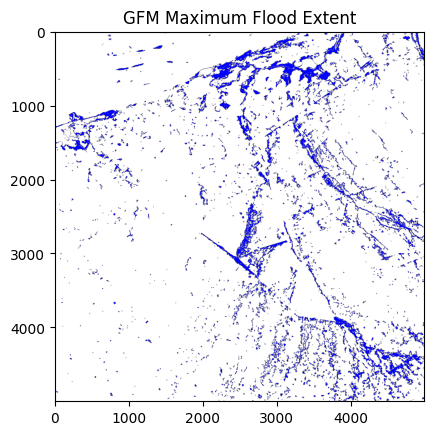

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['none', 'blue'])


plt.figure()
plt.imshow(result[:5000, :5000], cmap=cmap)
plt.title("GFM Maximum Flood Extent")
plt.show()